# Algorithmic Fairness, Accountability, and Ethics, Spring 2026

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from folktables import ACSDataSource

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import shap


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']
 
target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()] 
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values    
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

C:\Users\Abdel\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Features of original dataset
AGEP: Age

CIT: Citizenship status

COW: Class of worker

ENG: English proficiency

SCHL: Education level

MAR: Marital status

HINS1, HINS2, HINS4: Types of health insurance

RAC1P: Race

SEX: Gender

target_name = "PINCP": Person’s total income (continuous).

In [3]:
data_original

,AGEP,CIT,COW,ENG,SCHL,MAR,HINS1,HINS2,HINS4,RAC1P,SEX,target,PINCP
0,30,1,6.0,1.0,14.0,1,2,2,1,8,1,True,48500.0
6,21,1,4.0,NaN,16.0,5,2,1,2,1,1,False,7700.0
7,65,1,2.0,1.0,22.0,5,2,2,2,1,1,False,17200.0
10,33,1,1.0,1.0,14.0,3,2,2,1,1,1,False,12000.0
13,18,1,2.0,NaN,19.0,5,2,1,2,1,2,False,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,38,5,1.0,1.0,22.0,1,1,2,2,6,1,True,565280.0
378802,39,5,1.0,1.0,22.0,1,1,2,2,6,2,True,210000.0
378807,61,1,1.0,NaN,19.0,1,1,2,2,1,1,True,105000.0
378811,69,4,7.0,2.0,24.0,1,2,2,2,6,1,False,30000.0


## Preprocessing

 - This removes invalid or irrelevant rows:

 - Removes missing gender or race values.

 - Keeps only adults (AGEP > 16).

 - Removes very low income (< $100) and people with 0 work hours.

 - Keeps only rows with a valid person weight (PWGTP >= 1).
 
 - sex: Saves the SEX column for bias or fairness analysis later.

 - Converts the income (PINCP) into a binary target:

 - target = True if income > threshold ($35,000 by default), else False.

In [4]:
data

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
0,30,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,21,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,65,True,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10,33,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,18,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,38,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378802,39,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378807,61,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
378811,69,True,True,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


# Task 1

## Train models logistic regression and random forest

In [5]:

# 1. Feature Engineering: Scale features for Logistic Regression [cite: 13]
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

scaler = StandardScaler()
X_train_lr[["AGEP"]] = scaler.fit_transform(X_train_lr[["AGEP"]])
X_test_lr[["AGEP"]] = scaler.transform(X_test_lr[["AGEP"]])

# Logistic Regression (white-box)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train)

lr_preds = lr_model.predict(X_test_lr)
lr_probs = lr_model.predict_proba(X_test_lr)[:, 1]

# Random Forest (black-box) — no scaling needed
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# 4. Report Accuracy [cite: 14]
lr_acc = accuracy_score(y_test, lr_preds)
rf_acc = accuracy_score(y_test, rf_preds)

print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"Random Forest Accuracy:      {rf_acc:.4f}")

Logistic Regression Accuracy: 0.7699
Random Forest Accuracy:      0.7460



## Statistical parity: P(Ŷ=1 | G=g)
## Equalized odds for T=1: TPR = P(Ŷ=1 | Y=1, G=g)
## Equalized odds for T=0: FPR = P(Ŷ=1 | Y=0, G=g)

In [6]:
def safe_rate(numerator, denominator):
    return numerator / denominator if denominator != 0 else np.nan


def compute_fairness_metrics(y_true, y_pred, groups):
    results = {}
    for g in np.unique(groups):
        mask = (groups == g)
        y_g = y_true[mask]
        pred_g = y_pred[mask]

        sp = np.mean(pred_g)  # P(Ŷ=1 | G=g)

        tp = np.sum((pred_g == 1) & (y_g == 1))
        fn = np.sum((pred_g == 0) & (y_g == 1))
        fp = np.sum((pred_g == 1) & (y_g == 0))
        tn = np.sum((pred_g == 0) & (y_g == 0))

        tpr = safe_rate(tp, tp + fn)  # EO(T=1)
        fpr = safe_rate(fp, fp + tn)  # EO(T=0)

        results[int(g)] = {
            "SP": float(sp),
            "TPR": float(tpr) if not np.isnan(tpr) else np.nan,
            "FPR": float(fpr) if not np.isnan(fpr) else np.nan
        }
    return results


def print_metrics_and_gaps(metrics, title):
    # groups are 1 (Male) and 2 (Female) in your output
    print(f"\n{title}")
    for g in sorted(metrics.keys()):
        print(f" Group {g}: SP={metrics[g]['SP']:.4f}, TPR={metrics[g]['TPR']:.4f}, FPR={metrics[g]['FPR']:.4f}")

    sp_gap = metrics[1]["SP"] - metrics[2]["SP"]
    tpr_gap = metrics[1]["TPR"] - metrics[2]["TPR"]
    fpr_gap = metrics[1]["FPR"] - metrics[2]["FPR"]

    print(" Gaps (Male - Female):")
    print(f"  Statistical Parity gap: {sp_gap:.4f}")
    print(f"  Equalized Odds gap (T=1, TPR): {tpr_gap:.4f}")
    print(f"  Equalized Odds gap (T=0, FPR): {fpr_gap:.4f}")


lr_metrics = compute_fairness_metrics(y_test, lr_preds, group_test)
rf_metrics = compute_fairness_metrics(y_test, rf_preds, group_test)

print_metrics_and_gaps(lr_metrics, "Logistic Regression fairness (before post-processing)")
print_metrics_and_gaps(rf_metrics, "Random Forest fairness (before post-processing)")


Logistic Regression fairness (before post-processing)
 Group 1: SP=0.6420, TPR=0.8519, FPR=0.3151
 Group 2: SP=0.5173, TPR=0.7735, FPR=0.2702
 Gaps (Male - Female):
  Statistical Parity gap: 0.1247
  Equalized Odds gap (T=1, TPR): 0.0785
  Equalized Odds gap (T=0, FPR): 0.0449

Random Forest fairness (before post-processing)
 Group 1: SP=0.6243, TPR=0.8183, FPR=0.3224
 Group 2: SP=0.5034, TPR=0.7345, FPR=0.2805
 Gaps (Male - Female):
  Statistical Parity gap: 0.1209
  Equalized Odds gap (T=1, TPR): 0.0837
  Equalized Odds gap (T=0, FPR): 0.0419


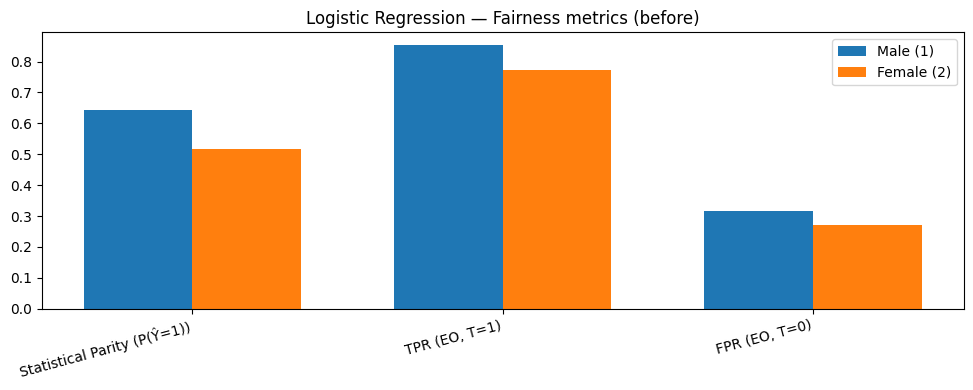

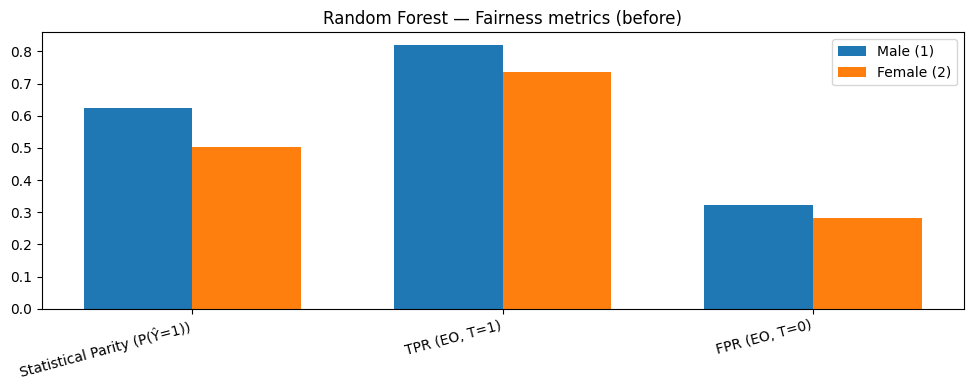

In [7]:
def plot_fairness(metrics, title):
    labels = ["Statistical Parity (P(Ŷ=1))", "TPR (EO, T=1)", "FPR (EO, T=0)"]
    male = [metrics[1]["SP"], metrics[1]["TPR"], metrics[1]["FPR"]]
    female = [metrics[2]["SP"], metrics[2]["TPR"], metrics[2]["FPR"]]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, male, width, label="Male (1)")
    plt.bar(x + width/2, female, width, label="Female (2)")
    plt.xticks(x, labels, rotation=15, ha="right")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_fairness(lr_metrics, "Logistic Regression — Fairness metrics (before)")
plot_fairness(rf_metrics, "Random Forest — Fairness metrics (before)")


## Post processing statistical parity

In [ ]:
# 8) Post-processing intervention for Statistical Parity

def post_process_statistical_parity(probs, groups, target_rate):
    """
    Adjust thresholds per group to approximately match a target positive prediction rate.
    This enforces statistical parity (positive rate similarity) but does not guarantee EO.
    """
    adjusted_preds = np.zeros(len(probs), dtype=int)

    for g in np.unique(groups):
        mask = (groups == g)
        group_probs = probs[mask]

        # threshold is the cutoff so that about 'target_rate' are predicted positive
        threshold = np.percentile(group_probs, 100 * (1 - target_rate))
        adjusted_preds[mask] = (group_probs >= threshold).astype(int)

    return adjusted_preds


# Logistic Regression post-processing
target_rate_lr = np.mean(lr_preds)  # keep overall positive rate similar
fair_lr_preds = post_process_statistical_parity(lr_probs, group_test, target_rate_lr)

fair_lr_acc = accuracy_score(y_test, fair_lr_preds)
fair_lr_metrics = compute_fairness_metrics(y_test, fair_lr_preds, group_test)

# Random Forest post-processing
target_rate_rf = np.mean(rf_preds)
fair_rf_preds = post_process_statistical_parity(rf_probs, group_test, target_rate_rf)

fair_rf_acc = accuracy_score(y_test, fair_rf_preds)
fair_rf_metrics = compute_fairness_metrics(y_test, fair_rf_preds, group_test)

print(f"\nLogistic Regression Accuracy: before={lr_acc:.4f}, after={fair_lr_acc:.4f}")
print(f"Random Forest Accuracy:      before={rf_acc:.4f}, after={fair_rf_acc:.4f}")

print_metrics_and_gaps(fair_lr_metrics, "Logistic Regression fairness (after SP post-processing)")
print_metrics_and_gaps(fair_rf_metrics, "Random Forest fairness (after SP post-processing)")



Logistic Regression Accuracy: before=0.7699, after=0.7637
Random Forest Accuracy:      before=0.7460, after=0.7407

Logistic Regression fairness (after SP post-processing)
 Group 1: SP=0.5830, TPR=0.7971, FPR=0.2496
 Group 2: SP=0.5830, TPR=0.8358, FPR=0.3391
 Gaps (Male - Female):
  Statistical Parity gap: 0.0000
  Equalized Odds gap (T=1, TPR): -0.0387
  Equalized Odds gap (T=0, FPR): -0.0895

Random Forest fairness (after SP post-processing)
 Group 1: SP=0.5671, TPR=0.7631, FPR=0.2621
 Group 2: SP=0.5671, TPR=0.7993, FPR=0.3431
 Gaps (Male - Female):
  Statistical Parity gap: 0.0000
  Equalized Odds gap (T=1, TPR): -0.0363
  Equalized Odds gap (T=0, FPR): -0.0810


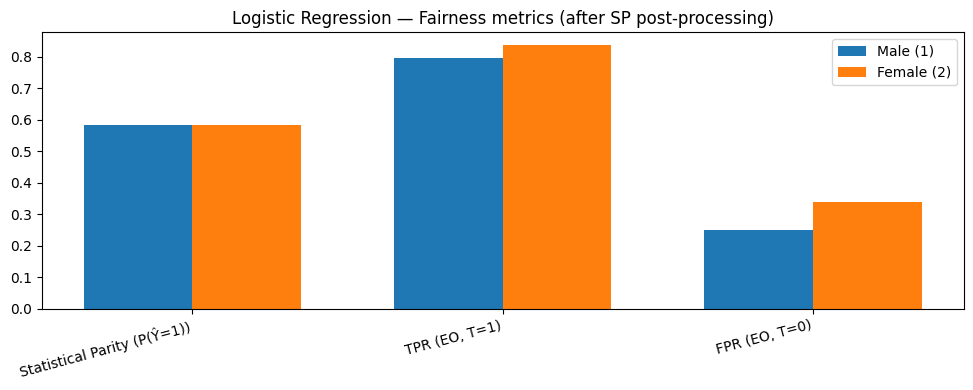

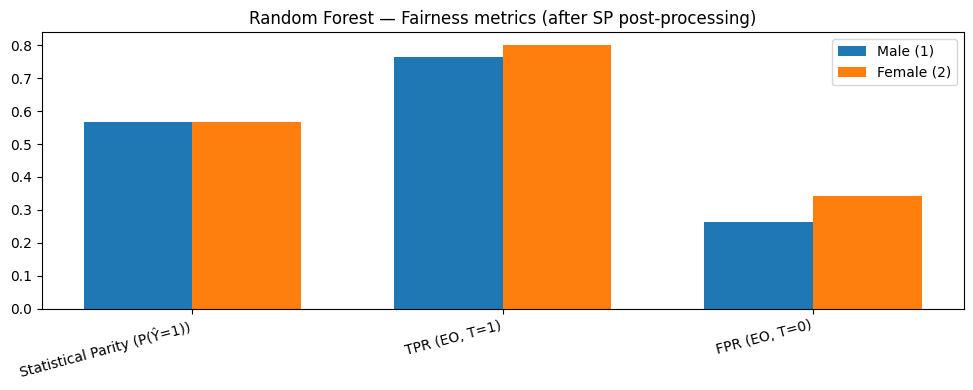

In [ ]:
# 9) Fairness plots (after)

plot_fairness(fair_lr_metrics, "Logistic Regression — Fairness metrics (after SP post-processing)")
plot_fairness(fair_rf_metrics, "Random Forest — Fairness metrics (after SP post-processing)")

## SHAP (Small subsample)

In [10]:
rng = np.random.RandomState(0)

N_BG = 200     # background sample (keep small)
N_SHAP = 300   # points to explain (keep small)

# Ensure numeric floats (avoid dtype/object issues)
X_train_lr_float = X_train_lr.astype(np.float64)
X_test_lr_float  = X_test_lr.astype(np.float64)

X_train_rf_float = X_train.astype(np.float64)
X_test_rf_float  = X_test.astype(np.float64)

bg_idx_lr = rng.choice(len(X_train_lr_float), size=min(N_BG, len(X_train_lr_float)), replace=False)
shap_idx_lr = rng.choice(len(X_test_lr_float), size=min(N_SHAP, len(X_test_lr_float)), replace=False)

bg_idx_rf = rng.choice(len(X_train_rf_float), size=min(N_BG, len(X_train_rf_float)), replace=False)
shap_idx_rf = rng.choice(len(X_test_rf_float), size=min(N_SHAP, len(X_test_rf_float)), replace=False)

X_bg_lr   = X_train_lr_float.iloc[bg_idx_lr]
X_shap_lr = X_test_lr_float.iloc[shap_idx_lr]

X_bg_rf   = X_train_rf_float.iloc[bg_idx_rf]
X_shap_rf = X_test_rf_float.iloc[shap_idx_rf]

## Logistic Regression SHAP

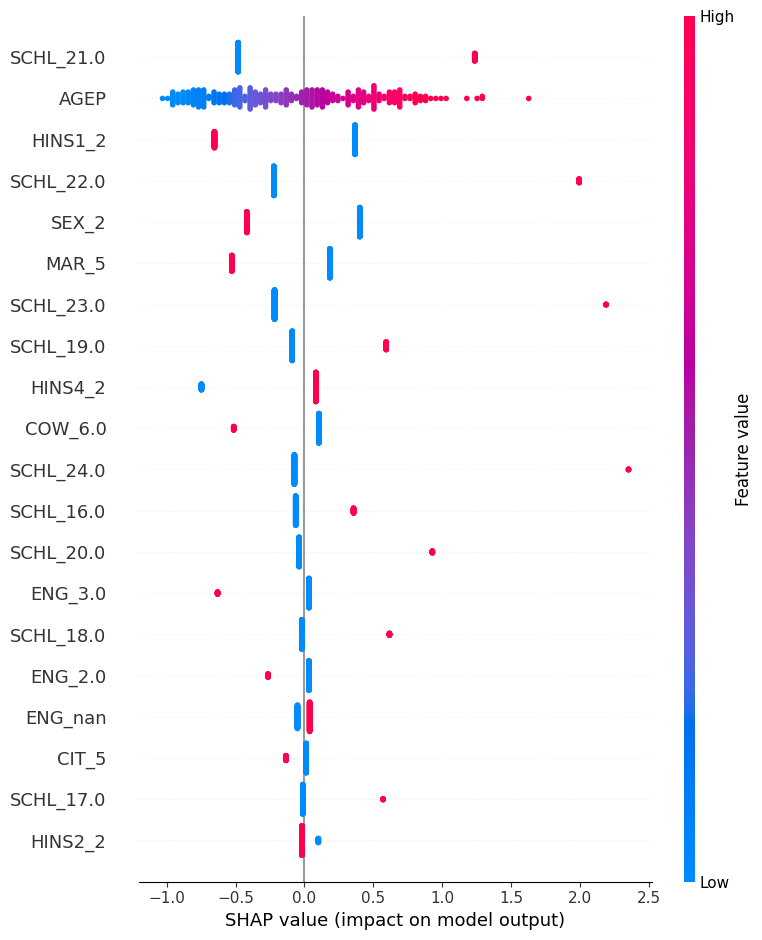

In [11]:
explainer_lr = shap.LinearExplainer(lr_model, X_bg_lr.values)
shap_vals_lr = explainer_lr.shap_values(X_shap_lr.values)

# Handle return type across SHAP versions
if isinstance(shap_vals_lr, list):
    shap_vals_lr = shap_vals_lr[1]

shap.summary_plot(
    np.asarray(shap_vals_lr, dtype=np.float64),
    X_shap_lr.values,
    feature_names=X_shap_lr.columns.tolist(),
    show=True
)

## Random Forest SHAP

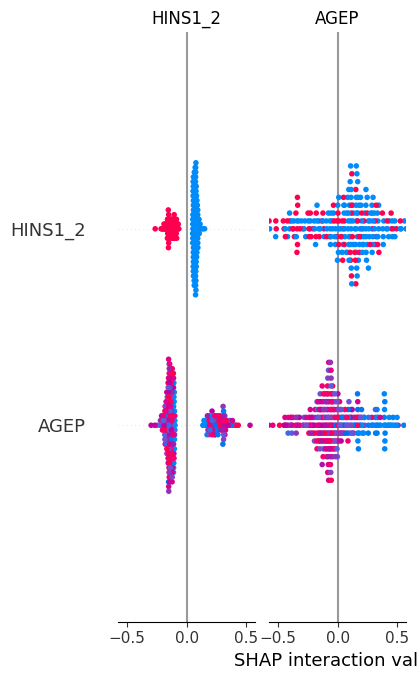

In [12]:
explainer_rf = shap.TreeExplainer(rf_model)

# Approximate SHAP for trees (much faster)
shap_vals_rf = explainer_rf.shap_values(X_shap_rf, approximate=True)

if isinstance(shap_vals_rf, list):
    shap_vals_rf = shap_vals_rf[1]

shap.summary_plot(
    np.asarray(shap_vals_rf, dtype=np.float64),
    X_shap_rf.values,
    feature_names=X_shap_rf.columns.tolist(),
    show=True
)

In [13]:
print(type(shap_vals_rf))
if isinstance(shap_vals_rf, list):
    print(len(shap_vals_rf), shap_vals_rf[0].shape, shap_vals_rf[1].shape)
else:
    print(shap_vals_rf.shape)

<class 'numpy.ndarray'>
(300, 55, 2)
